# Example walkthrough of analyzation and anonymization of a dataset containing sensitive attributes

### Import pyarxaas modules and classes

In [1]:
import pandas as pd
from pyarxaas import ARXaaS, Dataset, AttributeType
from pyarxaas.privacy_models import KAnonymity, LDiversityDistinct

### Import sensitive dataset
In this example a pandas DataFrame is created from a csv file, but any data source that can be converted to a DataFrame or Python dict would suffice.

In [2]:
df = pd.read_csv("../../data/dummy-dataset-260219.csv", sep=";")

In [3]:
df.head()

,Dummy_tag,ID,Navn,Alder,Sivilstatus,Barn,Innsatsgruppe,Innvandrerbakgrunn,Ledighetsstatus,Utdanning,Ytelse,Medisinsk forhold
0,dummy_data,PY827,Eirik,47,Ukjent,1,Situasjonsbestemt innsats,Togo,Delvis ledig,Høyere utd inntil 4 år,Tiltakspenger,Ingen
1,dummy_data,CX244,Ella,30,Gift,2,Varig tilpasset,Surinam,Ordinær tiltaksdeltaker,Grunnskole,Dagpenger,Ingen
2,dummy_data,ZE697,Solveig,37,Ukjent,1,Standard innsats,Malta,Delvis ledig,Grunnskole,Dagpenger,Ingen
3,dummy_data,AR215,Eirik,52,Ugift,1,Standard innsats,Norge,Andre arbeidssøkende,Høyere utd inntil 4 år,Uføretrygd,Ingen
4,dummy_data,CZ546,Heidi,37,Ukjent,3,Spesielt tilpasset,Surinam,Andre arbeidssøkende,Høyere utd over 4 år,Dagpenger,Ingen


### Create pyaaas.Dataset object
The Dataset class provide anonymization abstractions for a dataset.

In [4]:
dataset = Dataset.from_pandas(df)

### Set the AttributeType for the dataset fields
AttributeType defines the re-identification risk associated with a attribute.

In [5]:
dataset.set_attribute_type(AttributeType.IDENTIFYING,
                        'ID',
                        'Navn')

In [6]:
dataset.set_attribute_type(AttributeType.SENSITIVE,
                           'Medisinsk forhold')

In [7]:
dataset.set_attribute_type(AttributeType.INSENSITIVE,
                        'Dummy_tag')

In [8]:
dataset.set_attribute_type(AttributeType.QUASIIDENTIFYING,
                        'Innsatsgruppe',
                        'Innvandrerbakgrunn',
                        'Ledighetsstatus',
                        'Ytelse',
                        'Alder',
                        'Sivilstatus',
                        'Barn',
                        'Utdanning')

### Create service connection

creates an instance of the ARXaaS class that implements methods to interact with the service.

In [9]:
arxaas = ARXaaS("http://localhost:8080/") # connecting to service

### Create Risk Profile
Various privacy risks can be analyzed. These include re-identification risks for the prosecutor, journalist and marketer attacker models as well as risks derived from population uniqueness, which can be estimated with different statistical methods.

In [10]:
risk_profile = arxaas.risk_profile(dataset)

#### Re-Identification Risk Plots
The plots shows the Dataset has a high risk of re-identification.

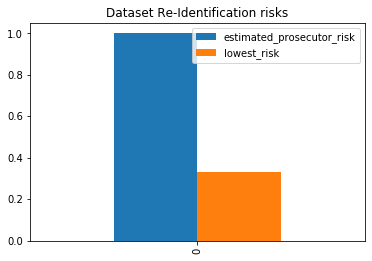

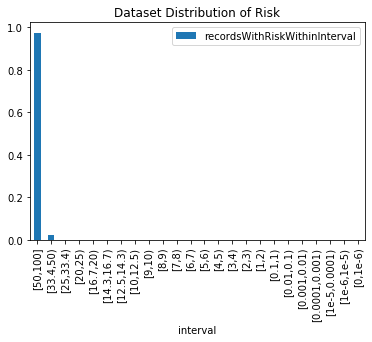

In [12]:
dataset_re_risk = risk_profile.re_identification_risk_dataframe()
dataset_re_risk[['estimated_prosecutor_risk', 'lowest_risk']].plot(kind="bar", yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], title="Dataset Re-Identification risks");

dataset_dis_risk = risk_profile.distribution_of_risk_dataframe()
dataset_dis_risk.plot(kind="bar", x="interval",y="recordsWithRiskWithinInterval", title="Dataset Distribution of Risk");

## Anonymize
If the dataset is not anonymous enough, we can attempt to anonymize it using PyARXaaS.

### Create generalization hierarchies
Before we can attempt to anonymize the dataset we need to create generalization hierarchies for generalizing the quasiidentifying attributes.

### Alder

#### Interval based hierarchies
Interval based hierarchies are well suited for continuous numeric values. Attributes such as age, income or credit score are typically generalized with a interval based hierarchy. 

In [13]:
from pyarxaas.hierarchy import IntervalHierarchyBuilder
ages = df["Alder"].tolist()
iterval_builder = IntervalHierarchyBuilder()
iterval_builder.add_interval(0, 18)
iterval_builder.add_interval(18, 30)
iterval_builder.add_interval(30, 60)
iterval_builder.add_interval(60, 120)
# Group the above intervals in order
iterval_builder.level(0)\
                .add_group(2)\
                .add_group(2);
age_hierarchy = arxaas.hierarchy(iterval_builder, ages)
# Age hierarchy
age_hierarchy[:10]

[['47', '[30, 60[', '[30, 120[', '*'],
 ['30', '[30, 60[', '[30, 120[', '*'],
 ['37', '[30, 60[', '[30, 120[', '*'],
 ['52', '[30, 60[', '[30, 120[', '*'],
 ['37', '[30, 60[', '[30, 120[', '*'],
 ['30', '[30, 60[', '[30, 120[', '*'],
 ['42', '[30, 60[', '[30, 120[', '*'],
 ['39', '[30, 60[', '[30, 120[', '*'],
 ['37', '[30, 60[', '[30, 120[', '*'],
 ['42', '[30, 60[', '[30, 120[', '*']]

### Barn

In [14]:
n_children = df["Barn"].unique().tolist()
n_childern_hierarchy_builder = IntervalHierarchyBuilder()
n_childern_hierarchy_builder.add_interval(-1, 1, "barnlose")
n_childern_hierarchy_builder.add_interval(1, 3, "har barn")
n_childern_hierarchy_builder.add_interval(3, 6, "har mange barn")
n_childern_hierarchy_builder.level(0)\
    .add_group(1, "barnlose")\
    .add_group(2, "har barn");
n_children_hierarchy = arxaas.hierarchy(n_childern_hierarchy_builder, n_children)
n_children_hierarchy

[['1', 'har barn', 'har barn', '*'],
 ['2', 'har barn', 'har barn', '*'],
 ['3', 'har mange barn', 'har barn', '*'],
 ['0', 'barnlose', 'barnlose', '*'],
 ['4', 'har mange barn', 'har barn', '*'],
 ['-1', 'barnlose', 'barnlose', '*'],
 ['5', 'har mange barn', 'har barn', '*']]

### Sivilstatus

#### Order based hierarchy

OrderHierarchyBuilder are suited for categorical attributes. Attributes such as country, education level and employment status. Order based hierarchies are built using groupings with optional labeling. This means that grouping is completed on the list of values as it is. The list has to be sorted according to some ordering before a usable hierarchy can be made. 

In [15]:
from pyarxaas.hierarchy import OrderHierarchyBuilder
s_statuses = sorted(df["Sivilstatus"].unique().tolist())
s_status_hierarchy_builder = OrderHierarchyBuilder()
s_status_hierarchy_builder.level(0)\
    .add_group(3, "Har/er Gift")\
    .add_group(2, "Ugift/Ukjent");
s_status_hierarchy = arxaas.hierarchy(s_status_hierarchy_builder, s_statuses)
s_status_hierarchy

[['Enke', 'Har/er Gift', '*'],
 ['Gift', 'Har/er Gift', '*'],
 ['Skilt', 'Har/er Gift', '*'],
 ['Ugift', 'Ugift/Ukjent', '*'],
 ['Ukjent', 'Ugift/Ukjent', '*']]

### Utdanning

In [16]:
educations = sorted(df["Utdanning"].unique().tolist())
# order values according to education level
educations[0], educations[2] = educations[2], educations[0] 
education_hierarchy_builder = OrderHierarchyBuilder()
education_hierarchy_builder.level(0)\
    .add_group(2, "hoyere utdannelse")\
    .add_group(3, "Ukjent eller grunnutdannelse");
education_hierarchy = arxaas.hierarchy(education_hierarchy_builder, educations)
education_hierarchy

[['Høyere utd over 4 år', 'hoyere utdannelse', '*'],
 ['Høyere utd inntil 4 år', 'hoyere utdannelse', '*'],
 ['Grunnskole', 'Ukjent eller grunnutdannelse', '*'],
 ['Ukjent', 'Ukjent eller grunnutdannelse', '*'],
 ['VGS', 'Ukjent eller grunnutdannelse', '*']]

### Read generalization hierarchies from file
Note that if the hierarchy does not have a header row in the csv file, please set header=None in read_csv() or the first row will be interpreted as a header and ARXaaS will throw an exception for the missing hierarchy data.

In [17]:
ytelse_hierarchy = pd.read_csv("../../hierarchies/Ytelse_hierarchy.csv", sep=";", header=None)
innsatsgruppe_hierarchy = pd.read_csv("../../hierarchies/innsatsgruppe_hierarchy.csv", sep=";", header=None)
innvandrerbakgrunn_hierarchy = pd.read_csv("../../hierarchies/innvandrerbakgrunn_hierarchy.csv", sep=";", header=None)
ledighetsstatus_hierarchy = pd.read_csv("../../hierarchies/ledighetsstatus_hierarchy.csv", sep=";", header=None)

### Set hierarchies

In [18]:
dataset.set_hierarchy('Ytelse', ytelse_hierarchy)
dataset.set_hierarchy("Innsatsgruppe", innsatsgruppe_hierarchy)
dataset.set_hierarchy("Innvandrerbakgrunn", innvandrerbakgrunn_hierarchy)
dataset.set_hierarchy("Ledighetsstatus", ledighetsstatus_hierarchy)
dataset.set_hierarchy("Alder", age_hierarchy)
dataset.set_hierarchy("Sivilstatus", s_status_hierarchy)
dataset.set_hierarchy("Barn", n_children_hierarchy)
dataset.set_hierarchy("Utdanning", education_hierarchy)

### Create Privacy Models
This well-known privacy model aims at protecting datasets from re-identification in the prosecutor model. A dataset is k-anonymous if each record cannot be distinguished from at least k-1 other records regarding the quasi-identifiers. Each group of indistinguishable records forms a so-called equivalence class.

In [19]:
kanon = KAnonymity(4)

LDiversity privacy model can be used to protect data against attribute disclosure by ensuring that each sensitive attribute has at least ℓ "well represented" values in each equivalence class.

In [20]:
ldiv = LDiversityDistinct(2, "Medisinsk forhold")

### With the hierarchies set we can attempt anonymization

In [21]:
anon_result = arxaas.anonymize(dataset,
                               privacy_models=[kanon, ldiv],
                               suppression_limit=1.0)

In [22]:
result = anon_result.dataset.to_dataframe()
result.head(20)

,Dummy_tag,ID,Navn,Alder,Sivilstatus,Barn,Innsatsgruppe,Innvandrerbakgrunn,Ledighetsstatus,Utdanning,Ytelse,Medisinsk forhold
0,dummy_data,*,*,*,Ugift/Ukjent,har barn,Situasjonsbestemt innsats,*,Delvis ledig,hoyere utdannelse,Tiltakspenger,Ingen
1,dummy_data,*,*,*,Har/er Gift,har barn,Varig tilpasset,*,ledig,Ukjent eller grunnutdannelse,Dagpenger,Ingen
2,dummy_data,*,*,*,Ugift/Ukjent,har barn,Standard innsats,*,Delvis ledig,Ukjent eller grunnutdannelse,Dagpenger,Ingen
3,dummy_data,*,*,*,Ugift/Ukjent,har barn,Standard innsats,*,Delvis ledig,hoyere utdannelse,Uføretrygd,Ingen
4,dummy_data,*,*,*,Ugift/Ukjent,har mange barn,Spesielt tilpasset,*,Delvis ledig,hoyere utdannelse,Dagpenger,Ingen
5,dummy_data,*,*,*,Har/er Gift,har barn,Spesielt tilpasset,*,Delvis ledig,Ukjent eller grunnutdannelse,Uføretrygd,Ingen
6,dummy_data,*,*,*,Har/er Gift,har barn,Situasjonsbestemt innsats,*,Delvis ledig,hoyere utdannelse,Tiltakspenger,Ingen
7,dummy_data,*,*,*,Har/er Gift,har barn,Varig tilpasset,*,ledig,Ukjent eller grunnutdannelse,Tiltakspenger,Ingen
8,dummy_data,*,*,*,Har/er Gift,har barn,Standard innsats,*,Delvis ledig,Ukjent eller grunnutdannelse,Dagpenger,Ingen
9,dummy_data,*,*,*,Har/er Gift,har barn,Standard innsats,*,ledig,Ukjent eller grunnutdannelse,Tiltakspenger,Ingen


###  Risk Profile for the anonymized dataset

In [23]:
anon_rp = anon_result.risk_profile

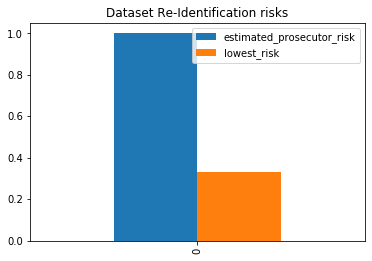

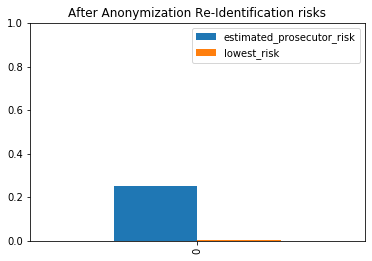

In [24]:
dataset_re_risk = risk_profile.re_identification_risk_dataframe()
dataset_re_risk[['estimated_prosecutor_risk', 'lowest_risk']].plot(kind="bar", yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], title="Dataset Re-Identification risks");

anon_re_risk = anon_rp.re_identification_risk_dataframe()
anon_re_risk[['estimated_prosecutor_risk', 'lowest_risk']].plot(kind="bar", yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], title="After Anonymization Re-Identification risks");

### Risk Distribution - Before and After

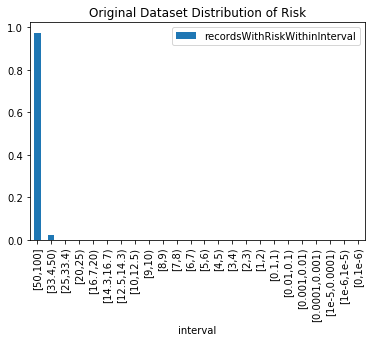

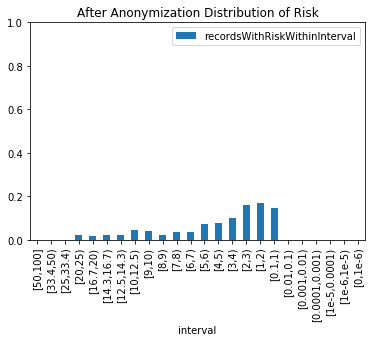

In [27]:
anon_dist_risk=anon_rp.distribution_of_risk_dataframe()
dataset_dis_risk.plot(kind="bar", x="interval",y="recordsWithRiskWithinInterval", yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], title="Original Dataset Distribution of Risk");
anon_dist_risk.plot(kind="bar", x="interval", y="recordsWithRiskWithinInterval", yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], title="After Anonymization Distribution of Risk");

### Anonymization Metrics

In [28]:
metrics = anon_result.anonymization_metrics

### Information about the levels the hierarchies used

In [29]:
metrics.attribute_generalization

[{'name': 'Alder',
  'type': 'QUASI_IDENTIFYING_ATTRIBUTE',
  'generalizationLevel': 3},
 {'name': 'Sivilstatus',
  'type': 'QUASI_IDENTIFYING_ATTRIBUTE',
  'generalizationLevel': 1},
 {'name': 'Barn',
  'type': 'QUASI_IDENTIFYING_ATTRIBUTE',
  'generalizationLevel': 1},
 {'name': 'Innsatsgruppe',
  'type': 'QUASI_IDENTIFYING_ATTRIBUTE',
  'generalizationLevel': 0},
 {'name': 'Innvandrerbakgrunn',
  'type': 'QUASI_IDENTIFYING_ATTRIBUTE',
  'generalizationLevel': 2},
 {'name': 'Ledighetsstatus',
  'type': 'QUASI_IDENTIFYING_ATTRIBUTE',
  'generalizationLevel': 1},
 {'name': 'Utdanning',
  'type': 'QUASI_IDENTIFYING_ATTRIBUTE',
  'generalizationLevel': 1},
 {'name': 'Ytelse',
  'type': 'QUASI_IDENTIFYING_ATTRIBUTE',
  'generalizationLevel': 0}]

### Information about Privacy Models configuration

In [30]:
metrics.privacy_models

[{'monotonicWithGeneralization': True,
  'attribute': 'Medisinsk forhold',
  'l': 2.0,
  'localRecodingSupported': True,
  'minimalClassSize': 2,
  'requirements': 4,
  'riskThresholdJournalist': 0.5,
  'riskThresholdMarketer': 0.5,
  'riskThresholdProsecutor': 0.5,
  'minimalClassSizeAvailable': True,
  'dataSubset': None,
  'populationModel': None,
  'subset': None,
  'monotonicWithSuppression': True,
  'sampleBased': False,
  'subsetAvailable': False},
 {'monotonicWithGeneralization': True,
  'k': 4,
  'minimalClassSize': 4,
  'requirements': 1,
  'riskThresholdJournalist': 0.25,
  'riskThresholdMarketer': 0.25,
  'riskThresholdProsecutor': 0.25,
  'localRecodingSupported': True,
  'minimalClassSizeAvailable': True,
  'dataSubset': None,
  'populationModel': None,
  'subset': None,
  'monotonicWithSuppression': True,
  'sampleBased': False,
  'subsetAvailable': False}]